# <center> Newman on custom trace and user graph </center>

In [49]:
import util
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

Load trace.

In [119]:
trace_path = "../Datasets/trace_test.txt"

Get authors.

In [120]:
Author = util.get_authors(trace_path)

Get users.

In [121]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [122]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N. We set the number of observation N[i,j] to the number of retweets by j.

/!\ N[i,j] : nb obs for j-->i /!\

/!\ E[i,j] : nb edges observed for j-->i /!\

In [145]:
# init
E = {e:0 for e in node_pairs}
N = {e:0 for e in node_pairs}

# read tweets
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet
    if rtid != -1:
        
        # update N[.,uid]
        for user in users.difference({uid}):
            N[uid, user] += 1
            
        # if retweetd user known update E[rtu,uid]
        if rtid in Author:
            rtu = Author[rtid]
            if rtu != uid: # no self-edges
                E[uid, rtu] += 1

Reduce the scale of N and E to avoid floats problems.

In [146]:
def scaling(x, I1, I2):
    # scales x from interval I1=[A,B] to I2=[a,b]
    A, B = I1[0], I1[1]
    a, b = I2[0], I2[1]
    return ((b-a)*x + a*B - A*b) / (B-A)

I1 = (min(E.values()), max(N.values()))
I2 = (0,1)
for e in N:
    N[e] = scaling(N[e], I1, I2)
    E[e] = scaling(E[e], I1, I2)
    
# # old scaling
# scaling_factor = min(E.values())
# for e in N:
#     N[e] /= scaling_factor
#     E[e] /= scaling_factor

In [147]:
print("min E, max N = ", min(E.values()), ",", max(N.values()))

min E, max N =  0.0 , 1.0


## 2. Iterations

Choose nb of repetitions and max iterations.

In [148]:
repetitions = 100
max_iter = 1000

Proceed.

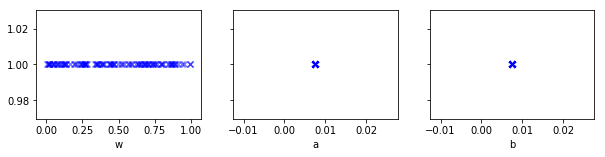

mean value for w : 0.46380615021913696
median value for w : 0.4497396299156923

mean value for a : 0.007608256767484929
median value for a : 0.007607909452884597

mean value for b : 0.007607255634959112
median value for b : 0.00760783499264011



In [149]:
# at each repetition we save the values of w, a and b
results = {'w':list(), 'a':list(), 'b':list()}

for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.random()
        a = random.random()
        b = random.random()

        # iter
        for l in range(max_iter):

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for (i,j) in N:
                Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
                Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])

            # update w,a,b
            w = sum(Q.values()) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for (i,j) in N:
                numerator_a += Q[i,j] * E[i,j]
                numerator_b += (1-Q[i,j]) * E[i,j]
                denominator_a += Q[i,j] * N[i,j]
                denominator_b += (1-Q[i,j]) * N[i,j]
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b

            # break if no sufficient evolution
            if np.all(np.abs([a-old_a, b-old_b, w-old_w]) < 0.001):
                break
            
        # add results to results dict
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        
    except:
        continue

    
# plot the results and compute mean,med
mean = dict()
med = dict()
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    mean[key] = np.mean(values)
    med[key] = np.median(values)
    ax[i].scatter(values, [1]*len(values), marker='x', alpha=.5, linewidths=.01, color='blue', label=key)
    ax[i].set_xlabel(key)
    
plt.show()
plt.close()

# print most probable
for key in results:
    print("mean value for {} : {}".format(key, mean[key]))
    print("median value for {} : {}".format(key, med[key]))
    print()

## 3. Result analysis

### 3.1 Sample generation

We generate a sample graph according to the posterior distribution.

Q[i,j] = proba of edge j-->i.

In [150]:
G_sample = nx.DiGraph()
G_sample.add_nodes_from(users)

for e in node_pairs:
    if random.random() < Q[e]:
        G_sample.add_edge(e[1], e[0])

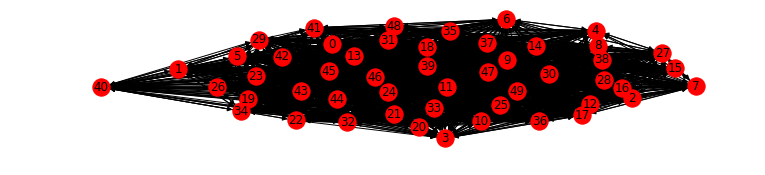

In [129]:
nx.draw(G_sample, with_labels=True)

Get real graph.

In [151]:
G_real = nx.DiGraph()
G_real.add_nodes_from(users)

for line in open("../Datasets/leadgraph_test.txt"):
    line = line.split()
    user = int(line[0])
    for leader in line[1:]:
        leader = int(leader)
        G_real.add_edge(leader, user)

Compare real graph with sample.

In [152]:
sampled_edges_in_real = set()
real_edges_in_sample = set()

for e in G_sample.edges:
    if e in G_real.edges:
        sampled_edges_in_real.add(e)

for e in G_real.edges:
    if e in G_sample.edges:
        real_edges_in_sample.add(e)
        
print("Proportion of edges from real graph in sample : ", len(real_edges_in_sample)/G_real.number_of_edges())
print("Proportion of edges from sample in real graph : ", len(sampled_edges_in_real)/G_sample.number_of_edges())

Proportion of edges from real graph in sample :  0.32432432432432434
Proportion of edges from sample in real graph :  0.08683068017366136


### 3.2 Other

Compare edges in real graph vs their posterior probability.

Text(0, 0.5, 'nb of edges in real graph')

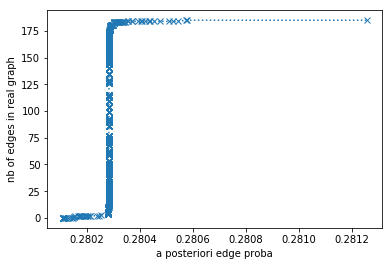

In [153]:
real_edges_count = list()
for (e,q) in sorted(Q.items(), key=itemgetter(1)):
    real_edges_count.append(0)
    for e in G_real.edges:
        if Q[e] <= q:
            real_edges_count[-1] += 1

plt.rcParams["figure.figsize"] = [6,4]
plt.plot(sorted(Q.values()), real_edges_count, marker='x', ls=':')
plt.xlabel("a posteriori edge proba")
plt.ylabel("nb of edges in real graph")

Estimate $\omega$ from real graph and get real values of $a,b$.

In [154]:
w_estimated_from_real_graph = G_real.number_of_edges() / (2*binom(n,2))
print("estimated w from real graph = ", w_estimated_from_real_graph)

a_numerator, a_denominator = 0, 0
for e in G_real.edges:
    a_numerator += E[e]
    a_denominator += N[e]
print("real a = ", a_numerator/a_denominator)

b_numerator, b_denominator = 0, 0
for e in node_pairs:
    if e not in G_real.edges:
        b_numerator += E[e]
        b_denominator += N[e]
print("real b = ", b_numerator/b_denominator)

estimated w from real graph =  0.07551020408163266
real a =  0.008845533451109923
real b =  0.00750185059507201


Compare expected degrees.

In [139]:
print("Expected degree observed : {} with variance ={}".format(2*sum(Q.values())/n, "?"))
print("Real expected degree : ", np.mean(G_real.degree()))

Expected degree observed : 77.33517794769949 with variance =?
Real expected degree :  15.95
